# Exploratory Data Analysis - Logistic Regression with Colour Palette Data in the HLS Colour Scheme
In this notebook we repeat the tests of notebook: __22__ but we convert the colour data to the Colour Scheme: __H, L, S__. The __H, L, S__ Colour Scheme is considered to be more accurate when making colour comparisons.<br/> 
__NOTE:__ the conversion from __R, G, B__ to __H, L, S__ Colour Schemes is not very efficient. Therefore this notebook can take quite some time to complete.

In [1]:
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
import warnings
from sklearn.exceptions import DataConversionWarning
import random
import matplotlib.pyplot as plt
import sys

%matplotlib inline

## Helper Functions

The standard <code>read_data()</code> function seen throughout the project. designed to simplify and standardize the data reading process. <br/>In addition the _Global_ variables associated with its function are defined along with the relitive paths to the data files.<br/>__NOTE:__ in a business environment this function would be placed into a pythin module and imported. Here it is included into the notebook to provide full transparency. 

In [2]:
# required modules
import numpy as np
import pandas as pd
import sqlite3
from sklearn import preprocessing
import colorsys

# groups
COLOURS      = 10
PALETTES     = 11
LRG_PALETTES = 12
IMAGE        = 13
TILES        = 14

# sets
TRAIN        = 20
TEST         = 21
VALIDATE     = 22

# targets
ARTIST       = 30
GENRE        = 31
STYLE        = 32

# array
DATA         = 40
CATAGORY     = 41
CATAGORY_NUM = 42
IMAGE_TAG    = 43
TILE_INDEX   = 44

# colour systems
HLS          = 50
RGB          = 51
RAW          = 52

# an overly complicated method of defining the data file path
data_file  = {COLOURS      : {TRAIN    : {ARTIST : "./data/colour_sets/artist_train_colours.npz",
                                          GENRE  : "./data/colour_sets/genre_train_colours.npz",
                                          STYLE  : "./data/colour_sets/style_train_colours.npz"},
                              TEST     : {ARTIST : "./data/colour_sets/artist_test_colours.npz",
                                          GENRE  : "./data/colour_sets/genre_test_colours.npz",
                                          STYLE  : "./data/colour_sets/style_test_colours.npz"} ,
                              VALIDATE : {ARTIST : "./data/colour_sets/artist_validation_colours.npz",
                                          GENRE  : "./data/colour_sets/genre_validation_colours.npz",
                                          STYLE  : "./data/colour_sets/style_validation_colours.npz"}},
              PALETTES     : {TRAIN    : {ARTIST : "./data/palette_sets/artist_train_palettes.npz",
                                          GENRE  : "./data/palette_sets/genre_train_palettes.npz",
                                          STYLE  : "./data/palette_sets/style_train_palettes.npz"} ,
                              TEST     : {ARTIST : "./data/palette_sets/artist_test_palettes.npz",
                                          GENRE  : "./data/palette_sets/genre_test_palettes.npz",
                                          STYLE  : "./data/palette_sets/style_test_palettes.npz"} ,
                              VALIDATE : {ARTIST : "./data/palette_sets/artist_validation_palettes.npz",
                                          GENRE  : "./data/palette_sets/genre_validation_palettes.npz",
                                          STYLE  : "./data/palette_sets/style_validation_palettes.npz"}},
              LRG_PALETTES : {TRAIN    : {ARTIST : "./data/large_palette_sets/artist_train_palettes.npz",
                                          GENRE  : "./data/large_palette_sets/genre_train_palettes.npz",
                                          STYLE  : "./data/large_palette_sets/style_train_palettes.npz"} ,
                              TEST     : {ARTIST : "./data/large_palette_sets/artist_test_palettes.npz",
                                          GENRE  : "./data/large_palette_sets/genre_test_palettes.npz",
                                          STYLE  : "./data/large_palette_sets/style_test_palettes.npz"} ,
                              VALIDATE : {ARTIST : "./data/large_palette_sets/artist_validation_palettes.npz",
                                          GENRE  : "./data/large_palette_sets/genre_validation_palettes.npz",
                                          STYLE  : "./data/large_palette_sets/style_validation_palettes.npz"}},
              IMAGE        : {TRAIN    : {ARTIST : "./data/full_image_feature_sets/artist_train_features.npz",
                                          GENRE  : "./data/full_image_feature_sets/genre_train_features.npz",
                                          STYLE  : "./data/full_image_feature_sets/style_train_features.npz"} ,
                              TEST     : {ARTIST : "./data/full_image_feature_sets/artist_test_features.npz",
                                          GENRE  : "./data/full_image_feature_sets/genre_test_features.npz",
                                          STYLE  : "./data/full_image_feature_sets/style_test_features.npz"} ,
                              VALIDATE : {ARTIST : "./data/full_image_feature_sets/artist_validation_features.npz",
                                          GENRE  : "./data/full_image_feature_sets/genre_validation_features.npz",
                                          STYLE  : "./data/full_image_feature_sets/style_validation_features.npz"}},
              TILES        : {TRAIN    : {ARTIST : "./data/feature_sets/artist_train_features.npz",
                                          GENRE  : "./data/feature_sets/genre_train_features.npz",
                                          STYLE  : "./data/feature_sets/style_train_features.npz"} ,
                              TEST     : {ARTIST : "./data/feature_sets/artist_test_features.npz",
                                          GENRE  : "./data/feature_sets/genre_test_features.npz",
                                          STYLE  : "./data/feature_sets/style_test_features.npz"} ,
                              VALIDATE : {ARTIST : "./data/feature_sets/artist_validation_features.npz",
                                          GENRE  : "./data/feature_sets/genre_validation_features.npz",
                                          STYLE  : "./data/feature_sets/style_validation_features.npz"}}}

# Create a DB connection between python and the file system
conn = sqlite3.connect("./data/database/artist.db")

# the fuction that provides a standard data read method
def read_data(data_group, data_set, data_target, data_type, colour_system = RGB):
    
    # read the data file
    data = np.load(data_file[data_group][data_set][data_target], allow_pickle=True)

    # if tile index is requested
    if   data_type    == TILE_INDEX:
        # when group is tiles, return the tile indexes
        if data_group == TILES:
            return pd.DataFrame(data["arr_3"], columns = {"tile_index"})
        # otherwise, just return an emtpy dataset
        else:
            return pd.DataFrame(columns = {"tile_index"})
    # if image tags are requested
    elif data_type == IMAGE_TAG:
        return pd.DataFrame(data["arr_2"], columns = {"image_tag"})
    # if catagory data is requested
    elif data_type == CATAGORY:
        return pd.DataFrame(data["arr_1"], columns = {"catagory"})
    # if catagory_num is requested
    elif data_type == CATAGORY_NUM:
        # select data for the appropriate lookup table
        if   data_target == ARTIST: 
            query_string = "SELECT ID, NAME  AS VALUE FROM ARTIST"
        elif data_target == GENRE:
            query_string = "SELECT ID, GENRE AS VALUE FROM GENRE"
        else:
            query_string = "SELECT ID, STYLE AS VALUE FROM STYLE" 
        # build the lookup table
        lookup = pd.read_sql_query(query_string, conn)
        # get the catagory data
        data   = pd.DataFrame(data["arr_1"], columns = {"catagory"})
        # convert the catagory text labels to numeric catagory ids
        return pd.DataFrame(data["catagory"].apply(lambda x: lookup[lookup["VALUE"] == x]["id"].values[0]))
    # data requested
    elif data_group == COLOURS:
        # reshape the data and normalize
        return pd.DataFrame(preprocessing.normalize(data["arr_0"].reshape(data["arr_0"].shape[0],data["arr_0"].shape[1] * data["arr_0"].shape[2])))
    elif data_group == PALETTES or data_group == LRG_PALETTES:

        # extract the colour data
        colour_data = data["arr_0"]
        
        # find the datas dimensions
        records, _, palette_length, palette_layers = np.shape(colour_data)
        
        # reshape
        colour_data = colour_data.reshape(records * palette_length, palette_layers)
        
        # convert to a dataframe
        colour_data_df = pd.DataFrame(colour_data, columns =["r","g","b"])
        
        # process the data with different colour systems
        
        # hue, luminance, saturation
        if colour_system == HLS:
            
            # define a dataframe to hold the hls values
            hls_data_df = pd.DataFrame(columns =["h","l","s"])

            # loop through each record
            for row in colour_data_df.iterrows():
                
                # extract the r,g,b values and devide them by 255 ready to convert
                r, g, b = row[1].values/255

                # convert the values and add them to the dataframe
                hls_data_df.loc[len(hls_data_df)] = colorsys.rgb_to_hls(r, g, b)
            
            # create datasets and normalize
            hue        = pd.DataFrame(preprocessing.normalize(np.array(hls_data_df["h"]).reshape(records, palette_length)))
            luminance  = pd.DataFrame(preprocessing.normalize(np.array(hls_data_df["l"]).reshape(records, palette_length)))
            saturation = pd.DataFrame(preprocessing.normalize(np.array(hls_data_df["s"]).reshape(records, palette_length)))  
            
            # return values
            return hue, luminance, saturation
            
        # red, green, blue unnormalized
        elif colour_system == RAW:
            red   = pd.DataFrame(np.array(colour_data_df["r"]).reshape(records, palette_length))
            green = pd.DataFrame(np.array(colour_data_df["g"]).reshape(records, palette_length))
            blue  = pd.DataFrame(np.array(colour_data_df["b"]).reshape(records, palette_length))
            
            # return values
            return red, green, blue            
            
        # red, green, blue normalized- (default)
        else:
    
            # create datasets and normalize
            red   = pd.DataFrame(preprocessing.normalize(np.array(colour_data_df["r"]).reshape(records, palette_length)))
            green = pd.DataFrame(preprocessing.normalize(np.array(colour_data_df["g"]).reshape(records, palette_length)))
            blue  = pd.DataFrame(preprocessing.normalize(np.array(colour_data_df["b"]).reshape(records, palette_length)))
            
            # return values
            return red, green, blue

    elif data_group == IMAGE:
        # reshape the data and normalize
        return pd.DataFrame(preprocessing.normalize(data["arr_0"].reshape(data["arr_0"].shape[0],data["arr_0"].shape[2])))
    else:
        # normalize the data
        return pd.DataFrame(preprocessing.normalize(data["arr_0"])) 

The <code>get_colours()</code> function provides a list of colours the length of the value <code>no_of_colours</code>. This can be useful for consisten colours when used across multiple plots. 

In [4]:
# required modules
import random

# define colours used 
def get_colours(no_of_colours):
    
    # consistent randomness
    random.seed(42)
    
    # colour list
    colours = []

    # generate colours
    for i in range(no_of_colours):
        colours.append('#%06X' % random.randint(0, 0xFFFFFF))
    
    # return the colour list
    return colours

Generate sorted lists of _Artists, Genres_ & _Styles_. These are used in a variety of situations. These functions ensure that the lists are always defined in the same order.

In [5]:
# define data lists
artists = list(set(read_data(COLOURS, TRAIN, ARTIST, CATAGORY)["catagory"]))
styles  = list(set(read_data(COLOURS, TRAIN, STYLE,  CATAGORY)["catagory"]))
genres  = list(set(read_data(COLOURS, TRAIN, GENRE,  CATAGORY)["catagory"]))

# sort the lists
artists.sort()
styles.sort()
genres.sort()

The function <code>restructure_palette_data()</code> takes the __R, G__ & __B__ 3 layered dataset (_3 x 16_) and and flattens it out to a single layer (_1 x 48_). The columns are then relabelled 0 to 47 and the reshaped data is then returned 

In [4]:
def restructure_palette_data(data):
    
    # extract the layers
    layer0 = data[0]
    layer1 = data[1]
    layer2 = data[2]
    
    # concatenate the layers 
    concat_layer = pd.concat([layer0, layer1, layer2], axis = 1)
    
    # rename the columns
    concat_layer.columns = range(0,48)
    
    # return the data
    return concat_layer

In the function <code>review_c_values()</code> we compare the effects of different values of the hyperparameter <code>C</code>. The range of values used is: __0.001, 0.01, 0.1, 1__ & __10__. The results are then pltted side by side for comparison. <br/>
We have the ability to define the target from __ARTIST, GENRE__ & __STYLE__ with the Default: __ARTIST__ if not specified. We are also able to adjust the hyperparameter values <code>multi_class</code> and <code>solver</code>.

In [5]:
def review_c_values(target = ARTIST, multi_class = "auto", solver = "lbfgs", artwork_id = 1, colour_system = RGB):
    
    # prepare data
    X_train = restructure_palette_data(read_data(PALETTES, TRAIN, target, DATA, colour_system))
    y_train = read_data(PALETTES, TRAIN, target, CATAGORY)
    X_test  = restructure_palette_data(read_data(PALETTES, TEST,  target, DATA, colour_system))
    y_test  = read_data(PALETTES, TEST,  target, CATAGORY)
    
    # the regularization strength parameter values (C)
    C_vals = [0.001,0.01,0.1,1,10]

    # identifiy the correct column headings to use
    if  target  == STYLE:
        column_names_list    = styles
        fig_width_multiplier = 14
        label_font_size      = 19
    elif target == GENRE:
        column_names_list    = genres
        fig_width_multiplier = 12
        label_font_size      = 16
    else:
        column_names_list    = artists
        fig_width_multiplier = 4
        label_font_size      = 9
    
    # create a column heads dict from the list of artists
    i       = 0
    columns = {}
    for a in column_names_list:
        columns[i] = a
        i += 1

    # create a figure to grid plot into
    fig = plt.figure(figsize = (len(C_vals) * fig_width_multiplier, 5))
    sp  = 100 + (len(C_vals) * 10)
    
    # loop through the catagories
    for C in C_vals:

        # output progress
        sys.stdout.write("\rProcessing with C value: {: <5}".format(str(C)))

        # prepare subplot
        sp = sp + 1
        plt.subplot(sp)

        # create our pipeline with the current value of C
        logreg = make_pipeline(StandardScaler(),
                               LogisticRegression(C           = C, 
                                                  multi_class = multi_class, 
                                                  solver      = solver))

        # fit the data
        logreg.fit(X_train, y_train)

        # generate probability values for a single image
        data = pd.DataFrame(logreg.predict_proba([restructure_palette_data(read_data(PALETTES, TEST, target, DATA, colour_system)).iloc[artwork_id]]))

        # format data for the plot
        data.rename(columns = columns, inplace = True) 
        data_t = data.T

        # define plot axis labels
        plt.ylim(0,1)
        plt.subplot(sp).tick_params(axis = "x", rotation = 90, labelsize = label_font_size)

        # create subplot
        plt.bar(data_t.index,data_t[0], alpha = 0.2)

        # add subplot title
        plt.title(''.join(['C Value: ', str(C)]))

    # output progress
    sys.stdout.write("\rProcessing of C values: Completed")

    # prepare figure 
    fig.subplots_adjust(top = 0.85)
    fig.suptitle('Probability Plots for the Same Image with Increasing C values', fontsize = label_font_size)    

    # show our handy work
    plt.show() 

Display the artwork image associated with the given <code>image_tag</code> and label it with:
- the Title
- the Artist
- the Genre
- the Style
the image is loaded from file, whereas the details are extracted from the RDBMS.

In [6]:
# display an image file
def show_artwork(artwork_id, data_set = TEST):

    data_file_path  = "./data/"
    image_file_path = "".join([data_file_path, "images/"]) 
    image_tag       = read_data(IMAGE, data_set, ARTIST, IMAGE_TAG)["image_tag"][artwork_id]
    image_path      = "".join([image_file_path, "full_image_", image_tag ,".jpg"])

    # Load the image
    artwork_image = Image.open(image_path).convert('RGB')

    # convert it into a numpy array
    img_array  = np.array(artwork_image)

    # define query to retrieve artwork information from the database
    query_string = """
SELECT TITLE,
       NAME,
       GENRE,
       STYLE
FROM ARTWORK_IMAGE AS A,
     ARTWORK       AS B,
     ARTIST        AS C,
     GENRE         AS D,
     ARTWORK_STYLE AS E,
     STYLE         AS F
WHERE A.IMAGE_TAG = "{}"
AND   A.ARTWORK_ID = B.ID
AND   B.ARTIST_ID  = C.ID
AND   B.GENRE_ID   = D.ID
AND   B.ID         = E.ARTWORK_ID
AND   E.STYLE_ID   = F.ID
""".format(image_tag)

    # connect to the database
    conn = sqlite3.connect("./data/database/artist.db")
    
    # execute query
    lookup = pd.read_sql_query(query_string, conn)
    
    # extract the values from the returned dataset
    style = ""
    for rec in lookup.iterrows():
        title  = rec[1][0]
        artist = rec[1][1]
        genre  = rec [1][2]
        style  = ", ".join([rec[1][3], style  ]).strip(", ")

    # create a figure to grid plot into
    fig = plt.figure(figsize=(10, 8))

    # Plot the image
    plt.imshow(img_array)
    plt.xlabel("TITLE: {}\nARTIST: {}\nGENRE: {}\nSTYLE(S): {}".format(title, artist, genre, style), position=(0., 1e6), horizontalalignment='left')
    plt.xticks([])
    plt.yticks([])
    
    # show our handy work
    plt.show() 

In [7]:
# turn off scikit-learn Warnings
warnings.filterwarnings(action='ignore')

# Review _C_, _Multi Class_ & _Solver_ Values
Here we have a test bed that allows us to manually experiment with the effects brought about by changing the values of the hyperparameters and then comparing the results. Providing insights into the data.

In [8]:
artwork_id = 597

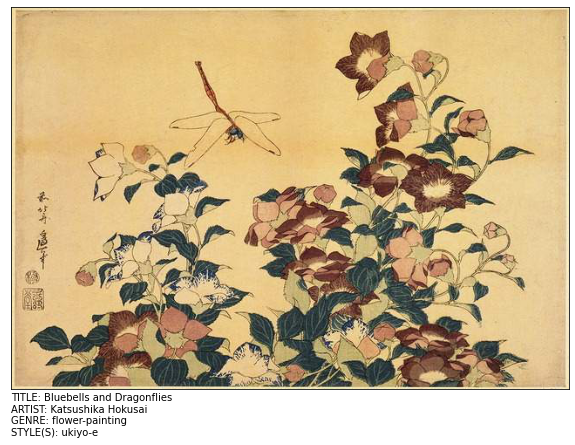

In [9]:
show_artwork(artwork_id) 

# Searching for _ARTIST_

Processing of C values: Completed

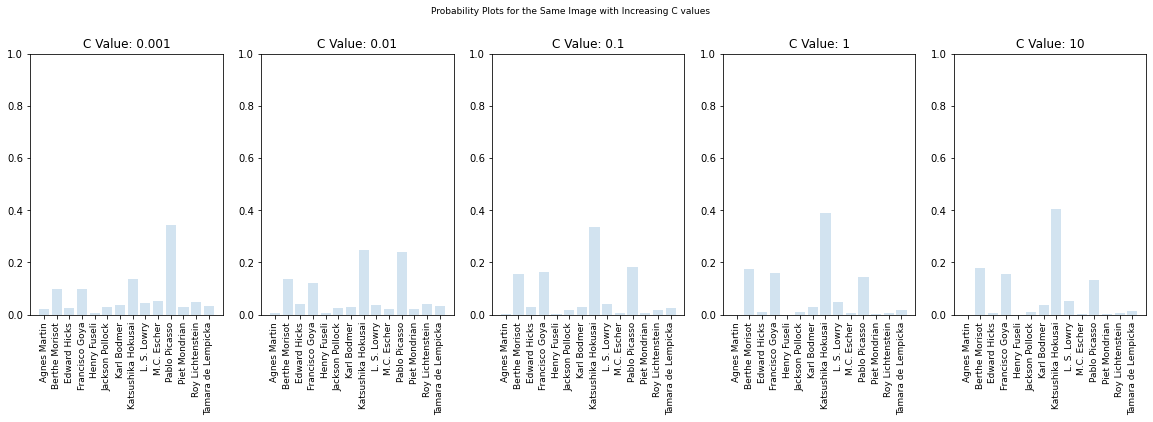

In [10]:
review_c_values(ARTIST, multi_class = "ovr", solver = "newton-cg", artwork_id = artwork_id, colour_system = HLS)

Processing of C values: Completed

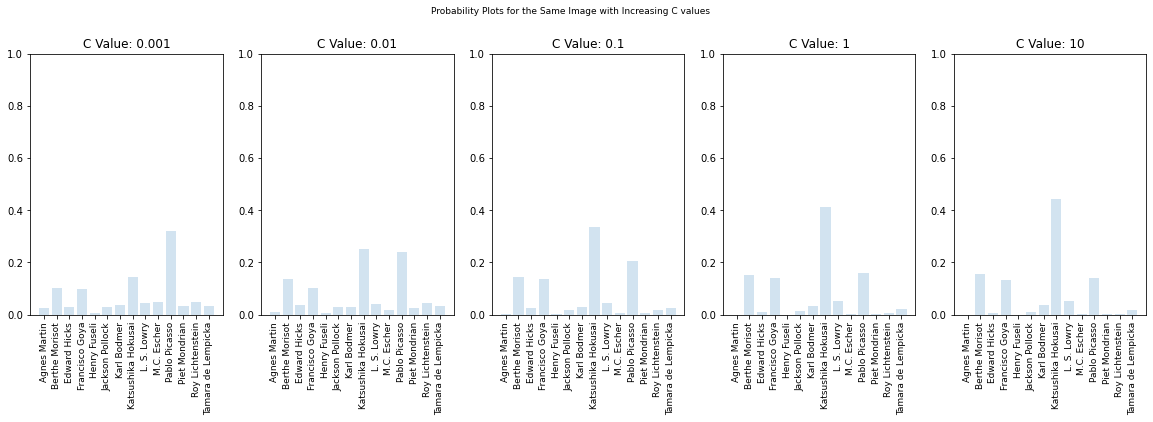

In [11]:
review_c_values(ARTIST, multi_class = "multinomial", solver = "newton-cg", artwork_id = artwork_id, colour_system = HLS)

Processing of C values: Completed

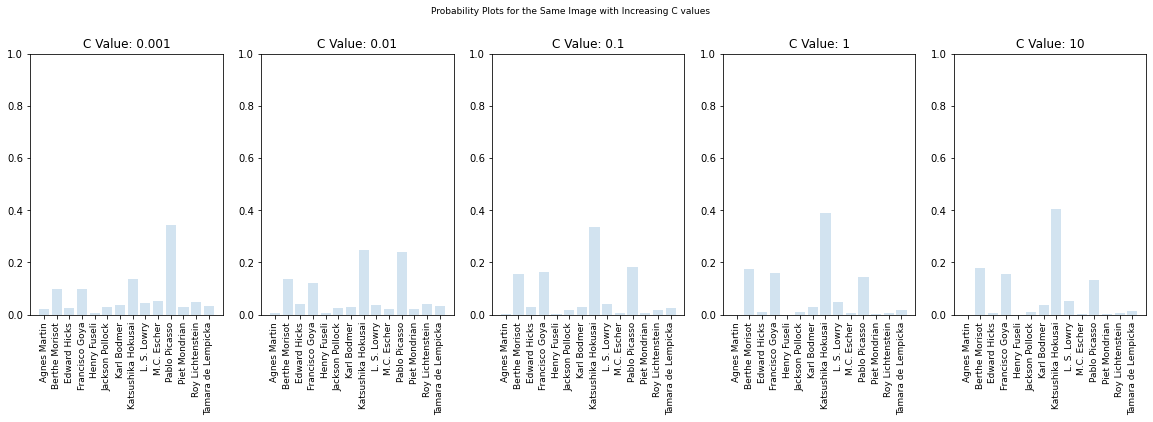

In [12]:
review_c_values(ARTIST, multi_class = "ovr", solver = "lbfgs", artwork_id = artwork_id, colour_system = HLS)

Processing of C values: Completed

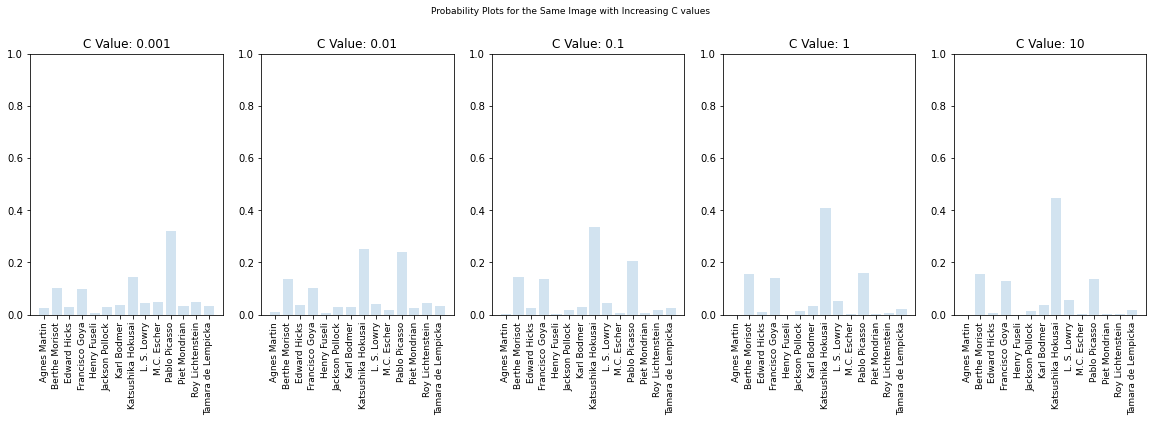

In [13]:
review_c_values(ARTIST, multi_class = "multinomial", solver = "lbfgs", artwork_id = artwork_id, colour_system = HLS)

Processing of C values: Completed

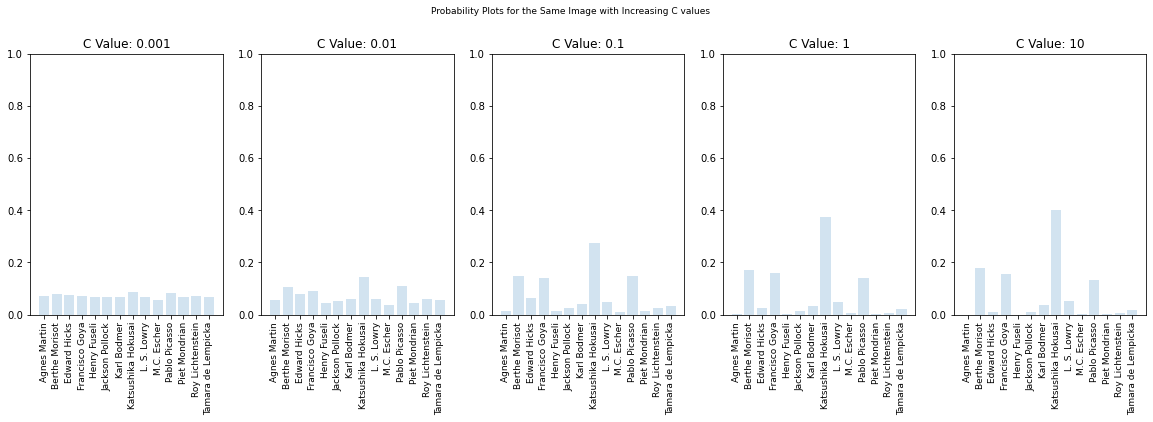

In [14]:
review_c_values(ARTIST, multi_class = "ovr", solver = "liblinear", artwork_id = artwork_id, colour_system = HLS)

# NOTE: solver liblinear does not support a multinomial backend. so only an ovr backend is tested here

Processing of C values: Completed

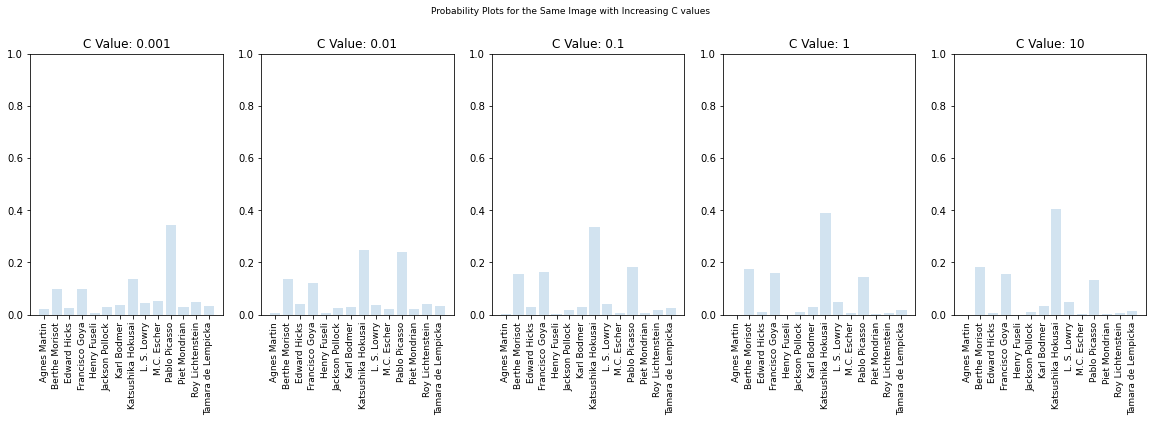

In [15]:
review_c_values(ARTIST, multi_class = "ovr", solver = "sag", artwork_id = artwork_id, colour_system = HLS)

Processing of C values: Completed

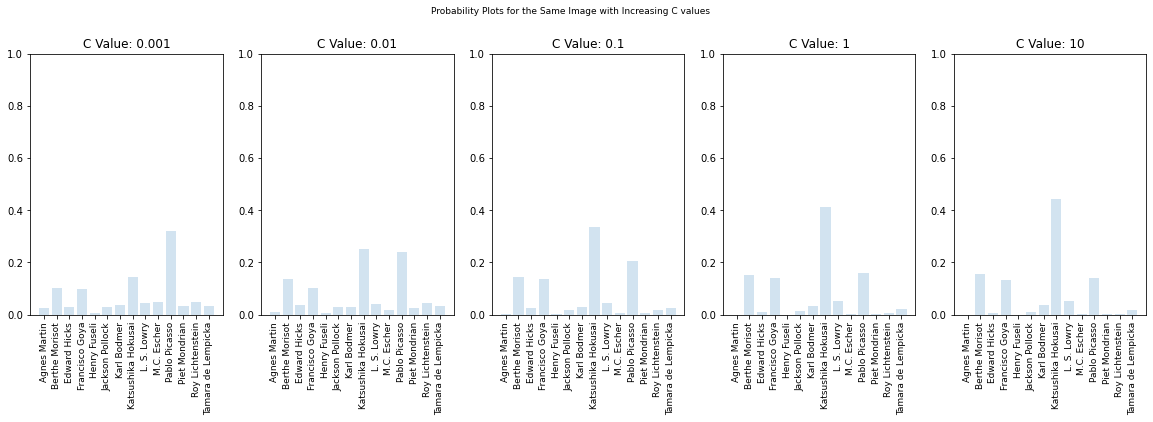

In [16]:
review_c_values(ARTIST, multi_class = "multinomial", solver = "sag", artwork_id = artwork_id, colour_system = HLS)

Processing of C values: Completed

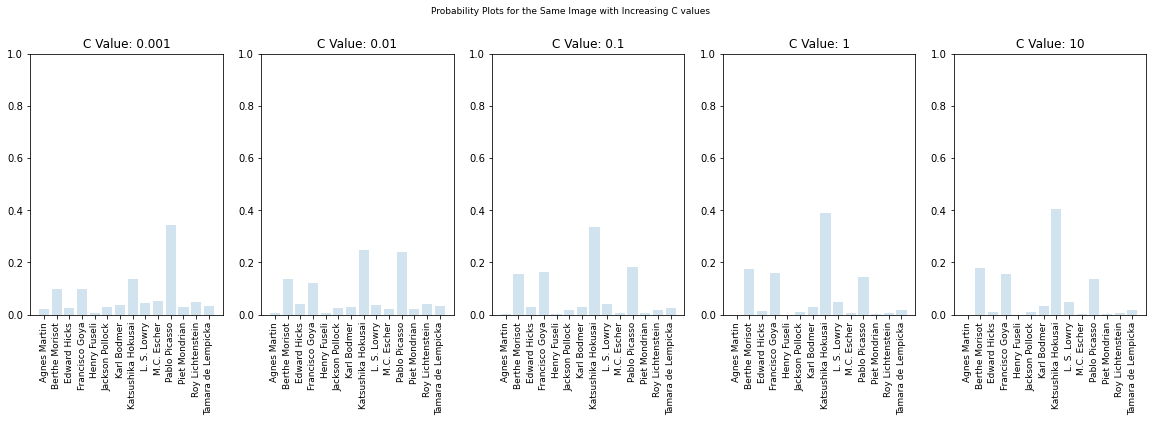

In [17]:
review_c_values(ARTIST, multi_class = "ovr", solver = "saga", artwork_id = artwork_id, colour_system = HLS)

Processing of C values: Completed

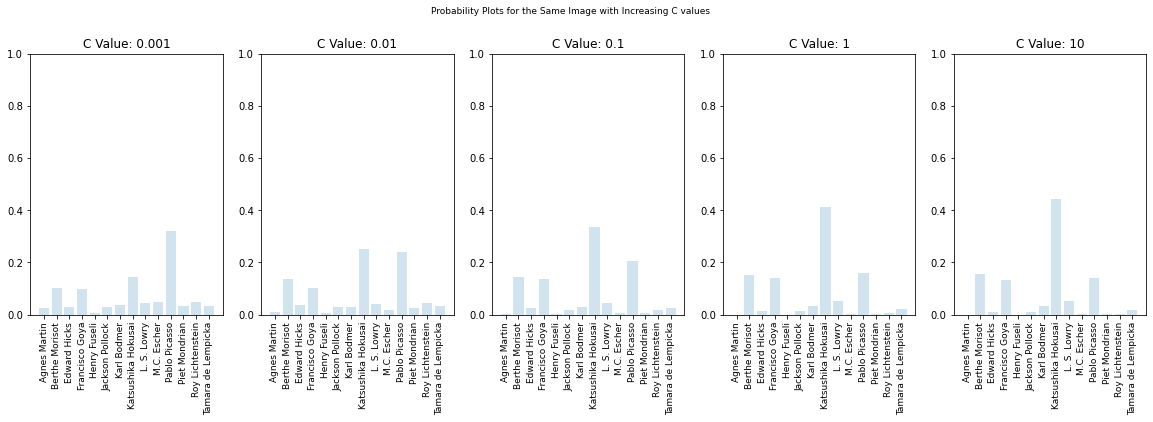

In [18]:
review_c_values(ARTIST, multi_class = "multinomial", solver = "saga", artwork_id = artwork_id, colour_system = HLS)

# Searching for _GENRE_

Processing of C values: Completed

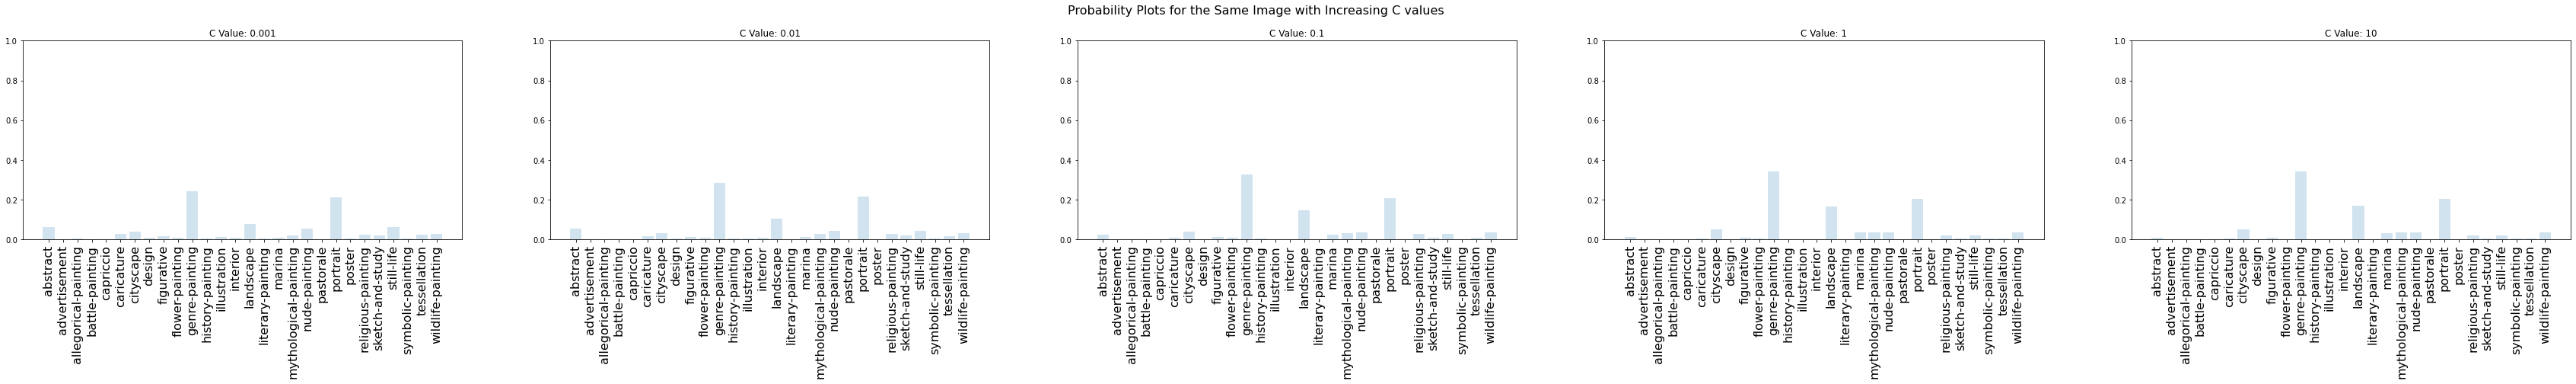

In [19]:
review_c_values(GENRE, multi_class = "ovr", solver = "newton-cg", artwork_id = artwork_id, colour_system = HLS)

Processing of C values: Completed

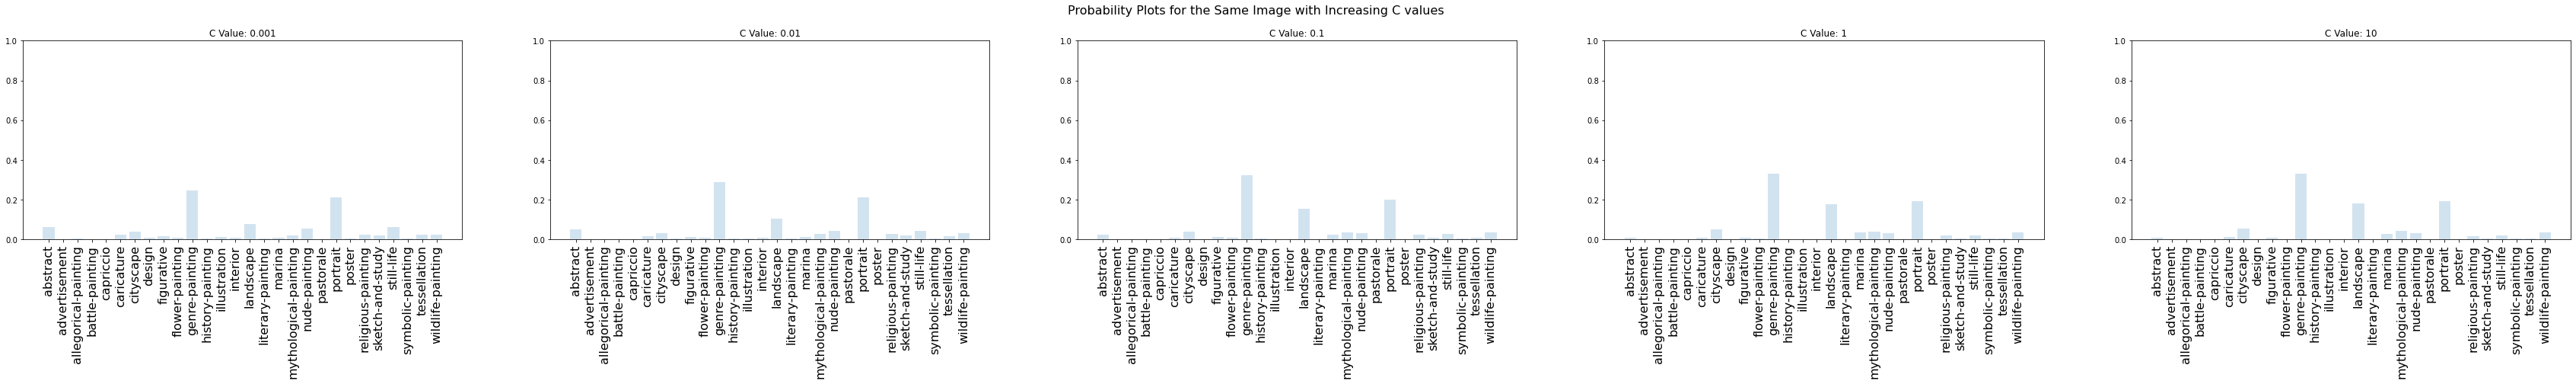

In [20]:
review_c_values(GENRE, multi_class = "multinomial", solver = "newton-cg", artwork_id = artwork_id, colour_system = HLS)

Processing of C values: Completed

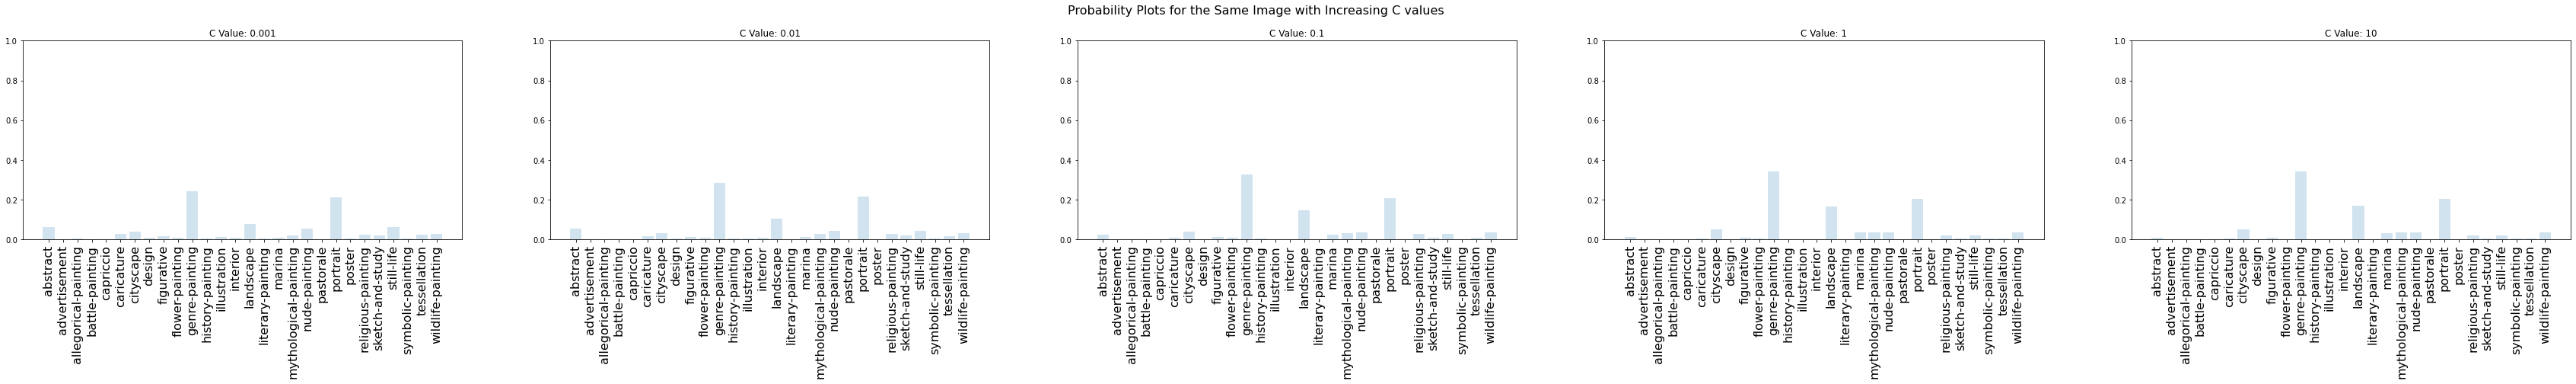

In [21]:
review_c_values(GENRE, multi_class = "ovr", solver = "lbfgs", artwork_id = artwork_id, colour_system = HLS)

Processing of C values: Completed

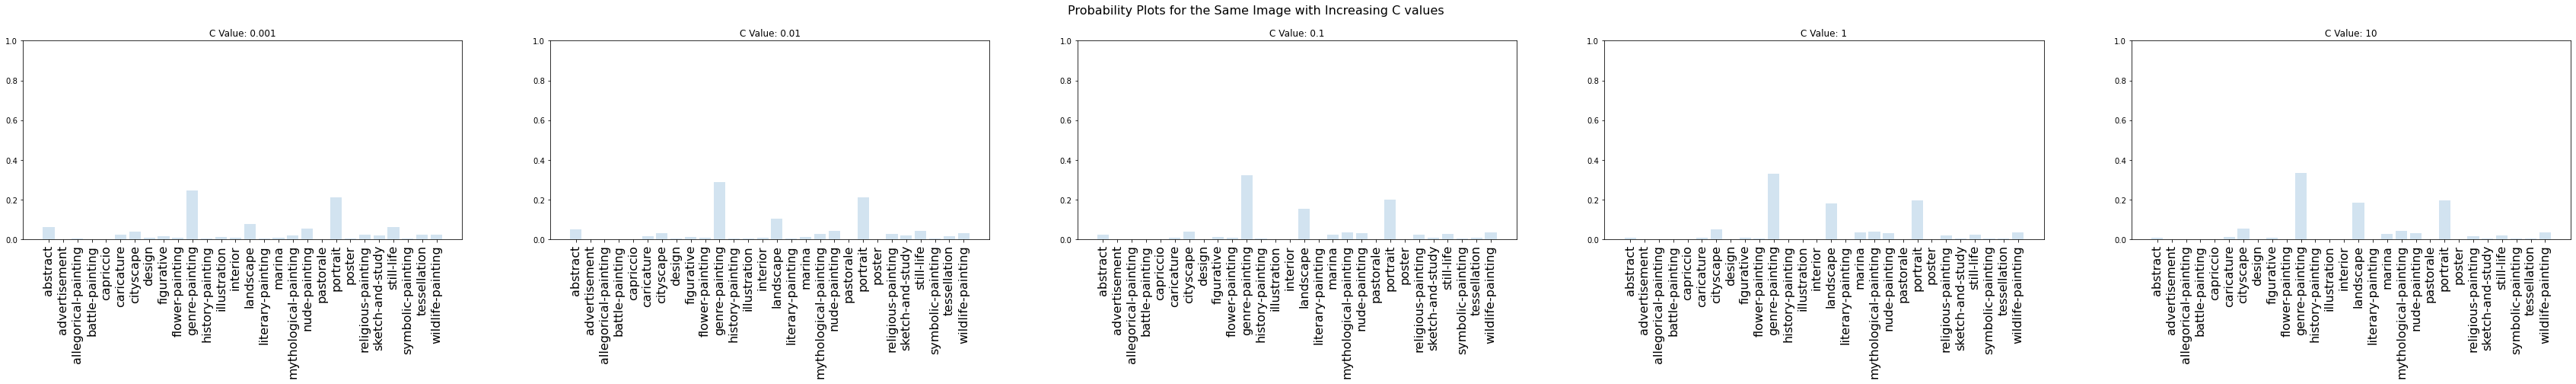

In [22]:
review_c_values(GENRE, multi_class = "multinomial", solver = "lbfgs", artwork_id = artwork_id, colour_system = HLS)

Processing of C values: Completed

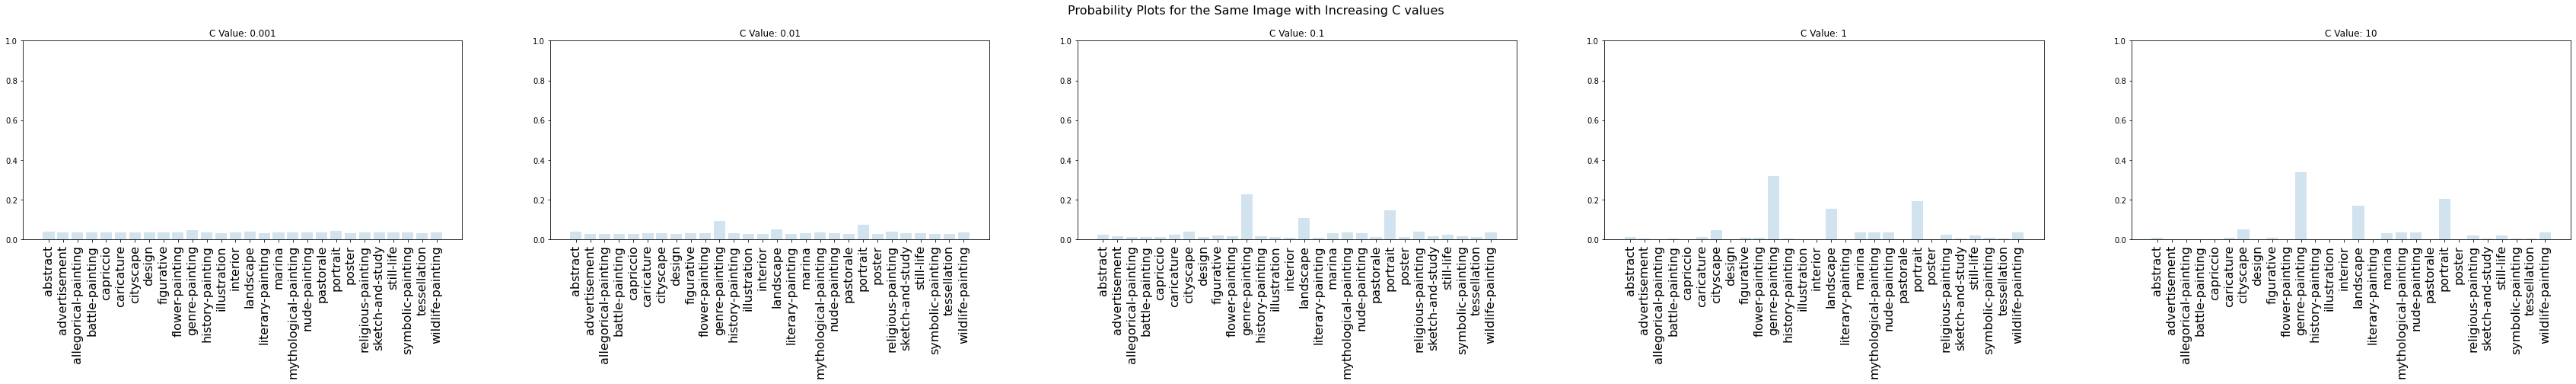

In [23]:
review_c_values(GENRE, multi_class = "ovr", solver = "liblinear", artwork_id = artwork_id, colour_system = HLS)

# NOTE: solver liblinear does not support a multinomial backend. so only an ovr backend is tested here

Processing of C values: Completed

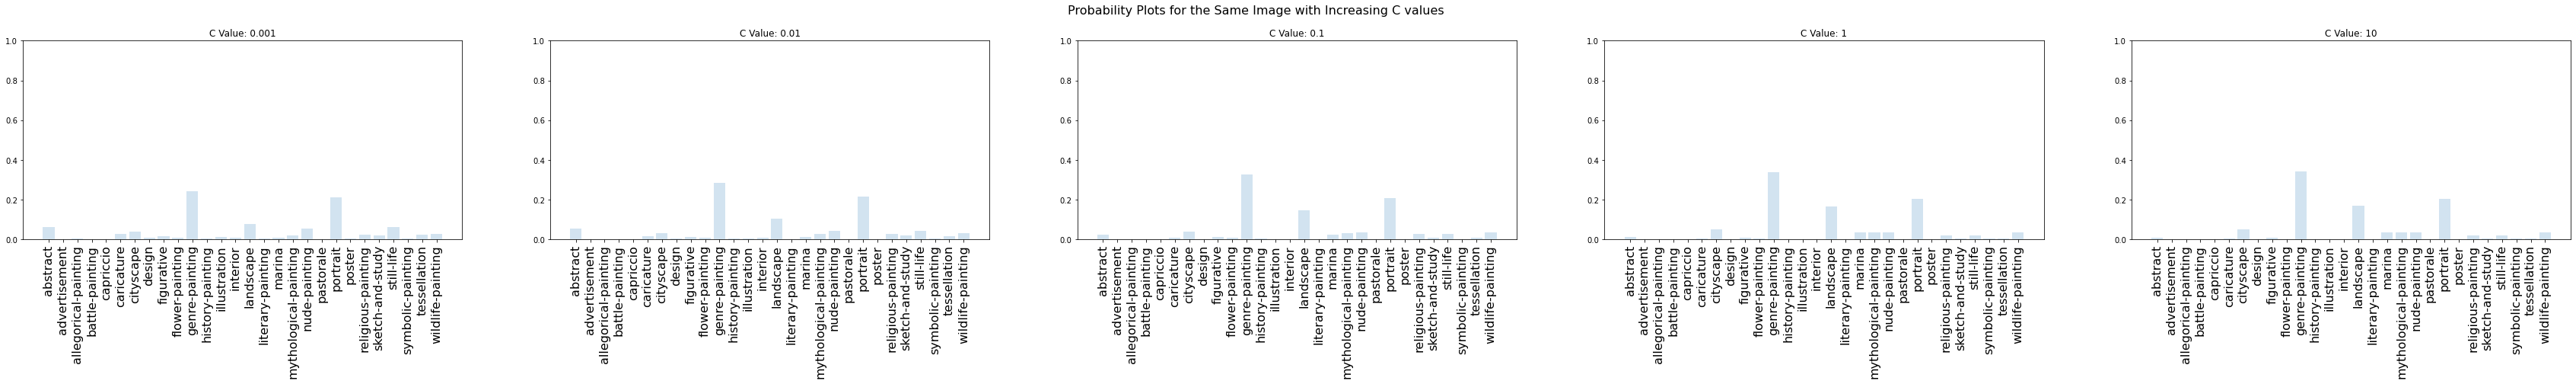

In [24]:
review_c_values(GENRE, multi_class = "ovr", solver = "sag", artwork_id = artwork_id, colour_system = HLS)

Processing of C values: Completed

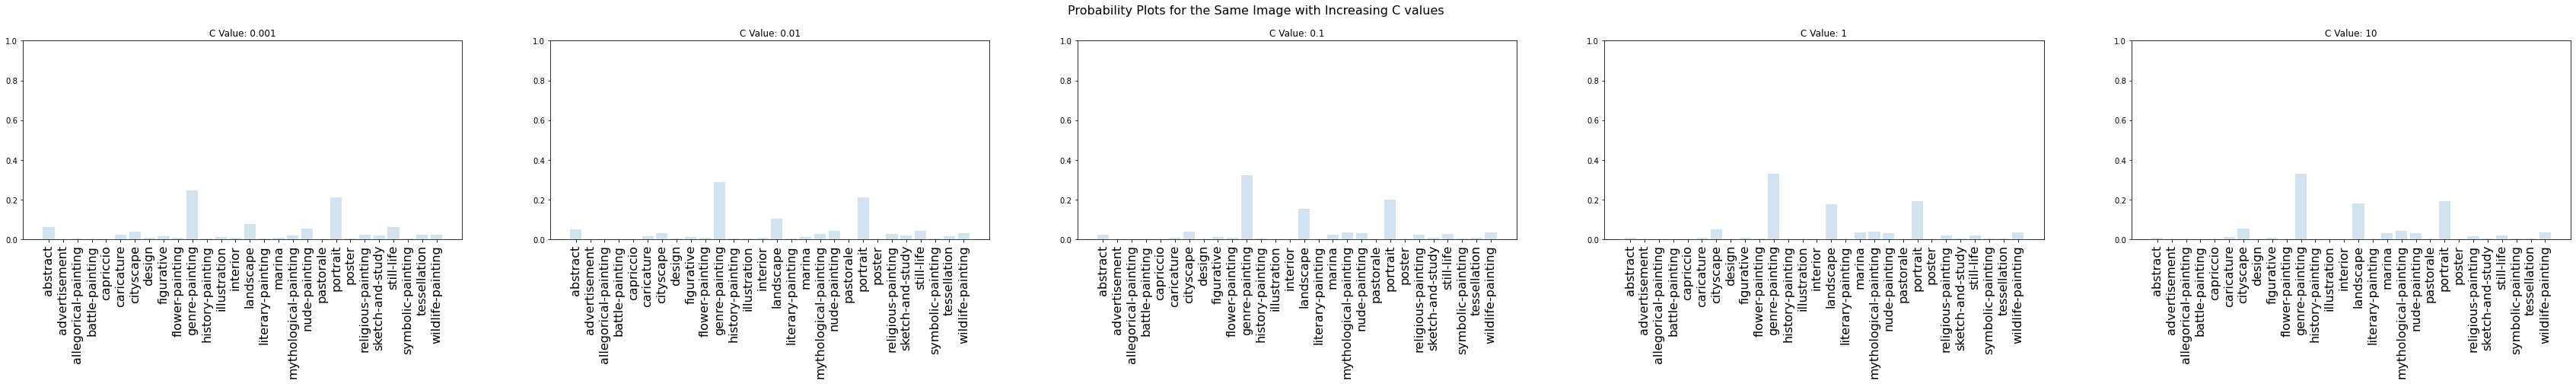

In [25]:
review_c_values(GENRE, multi_class = "multinomial", solver = "sag", artwork_id = artwork_id, colour_system = HLS)

Processing of C values: Completed

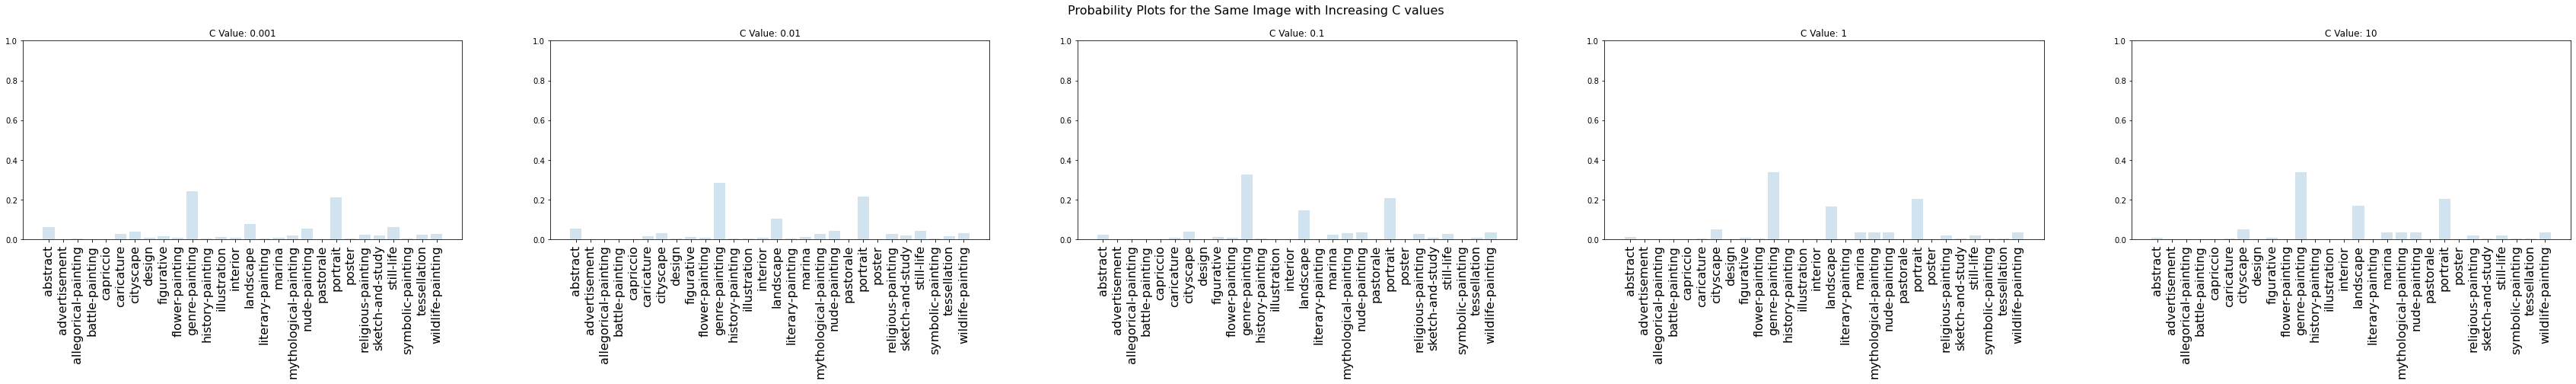

In [26]:
review_c_values(GENRE, multi_class = "ovr", solver = "saga", artwork_id = artwork_id, colour_system = HLS)

Processing of C values: Completed

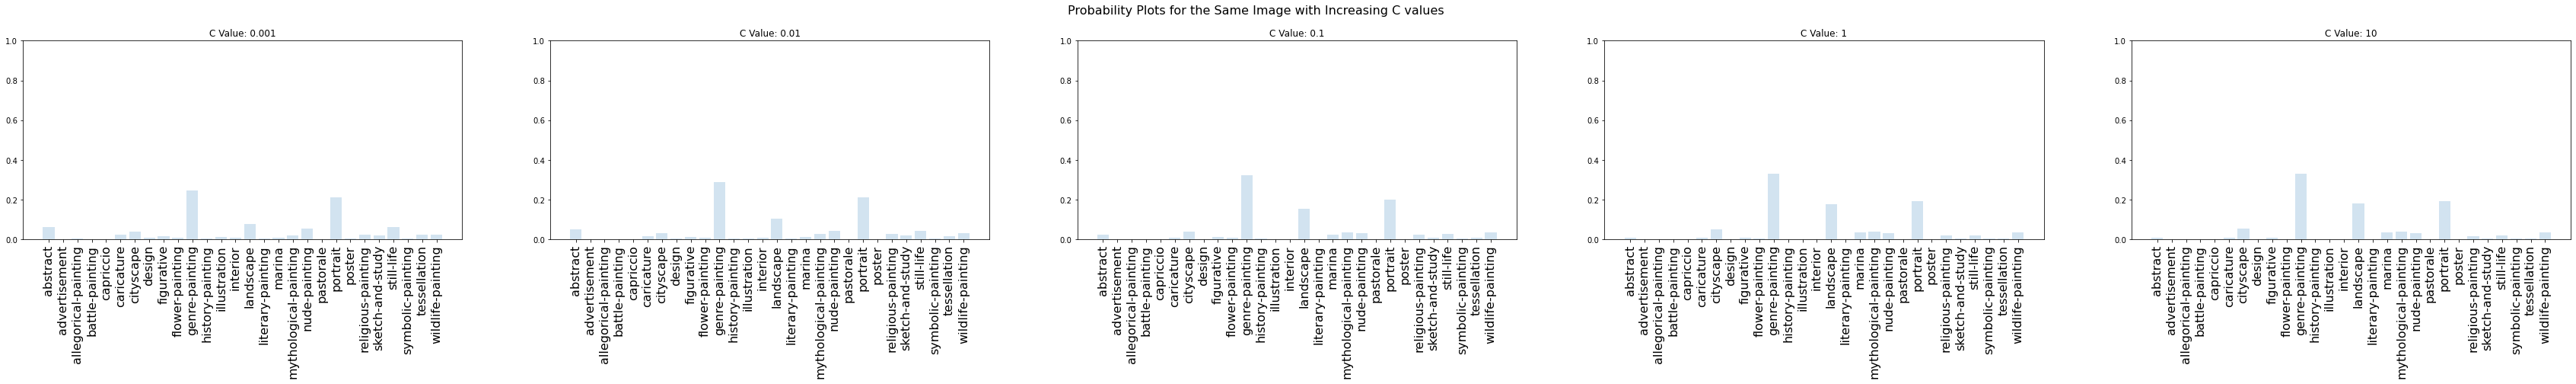

In [27]:
review_c_values(GENRE, multi_class = "multinomial", solver = "saga", artwork_id = artwork_id, colour_system = HLS)

# Searching for _STYLE_

Processing of C values: Completed

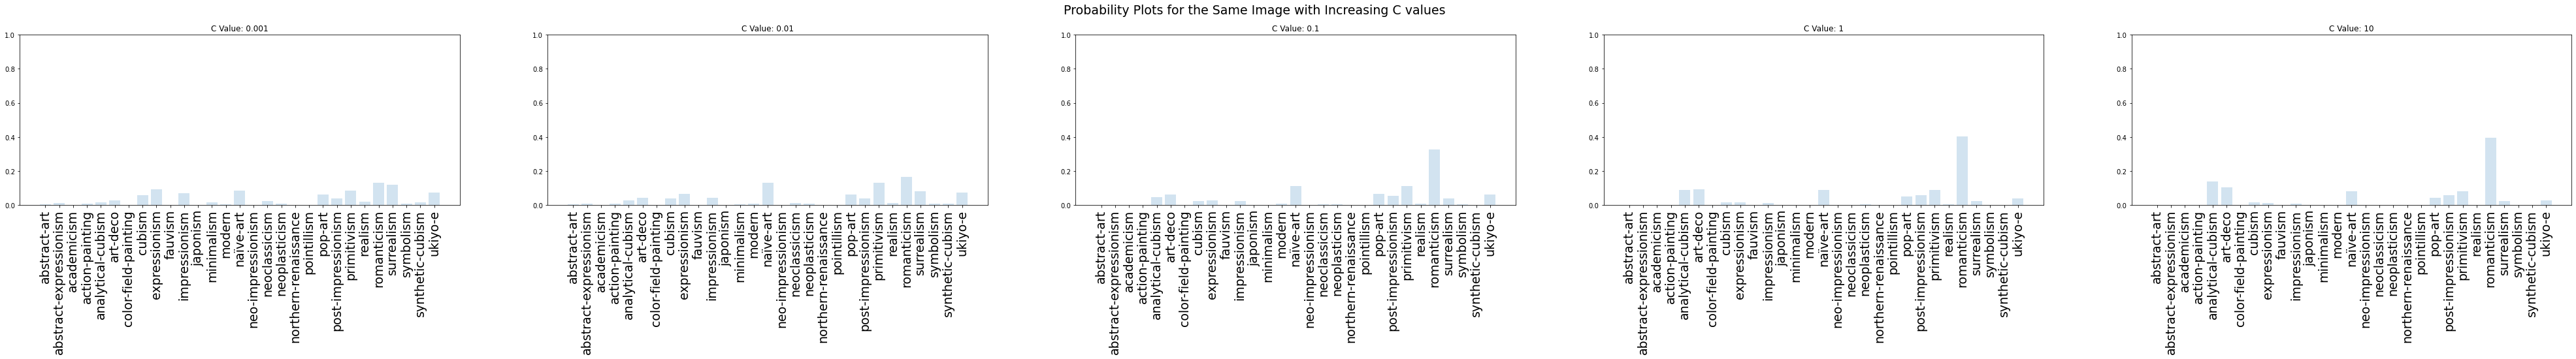

In [28]:
review_c_values(STYLE, multi_class = "ovr", solver = "newton-cg", artwork_id = artwork_id, colour_system = HLS)

Processing of C values: Completed

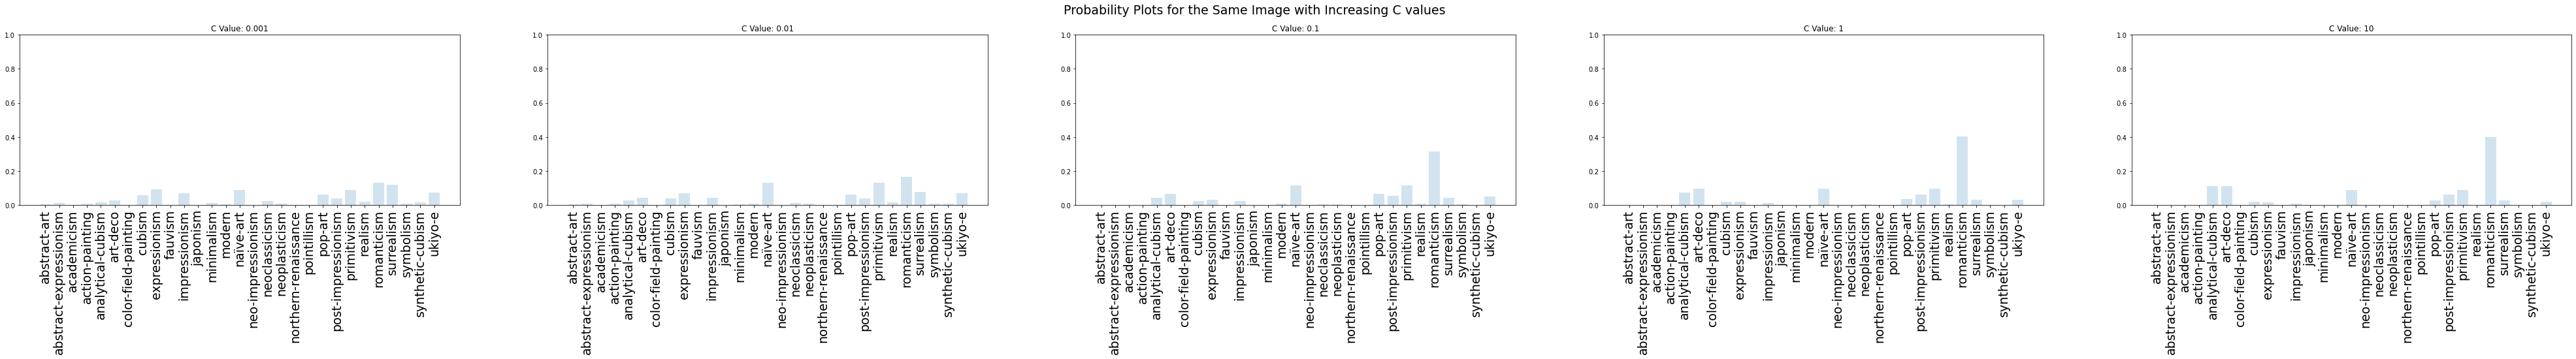

In [29]:
review_c_values(STYLE, multi_class = "multinomial", solver = "newton-cg", artwork_id = artwork_id, colour_system = HLS)

Processing of C values: Completed

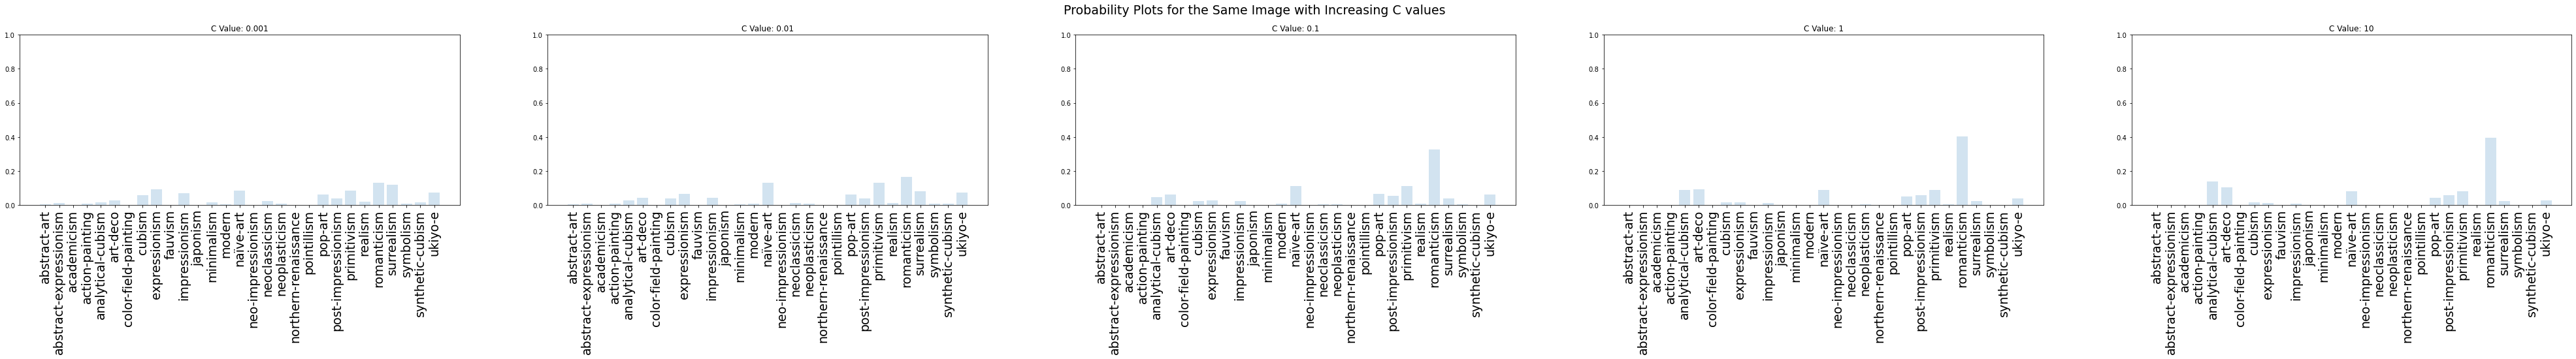

In [30]:
review_c_values(STYLE, multi_class = "ovr", solver = "lbfgs", artwork_id = artwork_id, colour_system = HLS)

Processing of C values: Completed

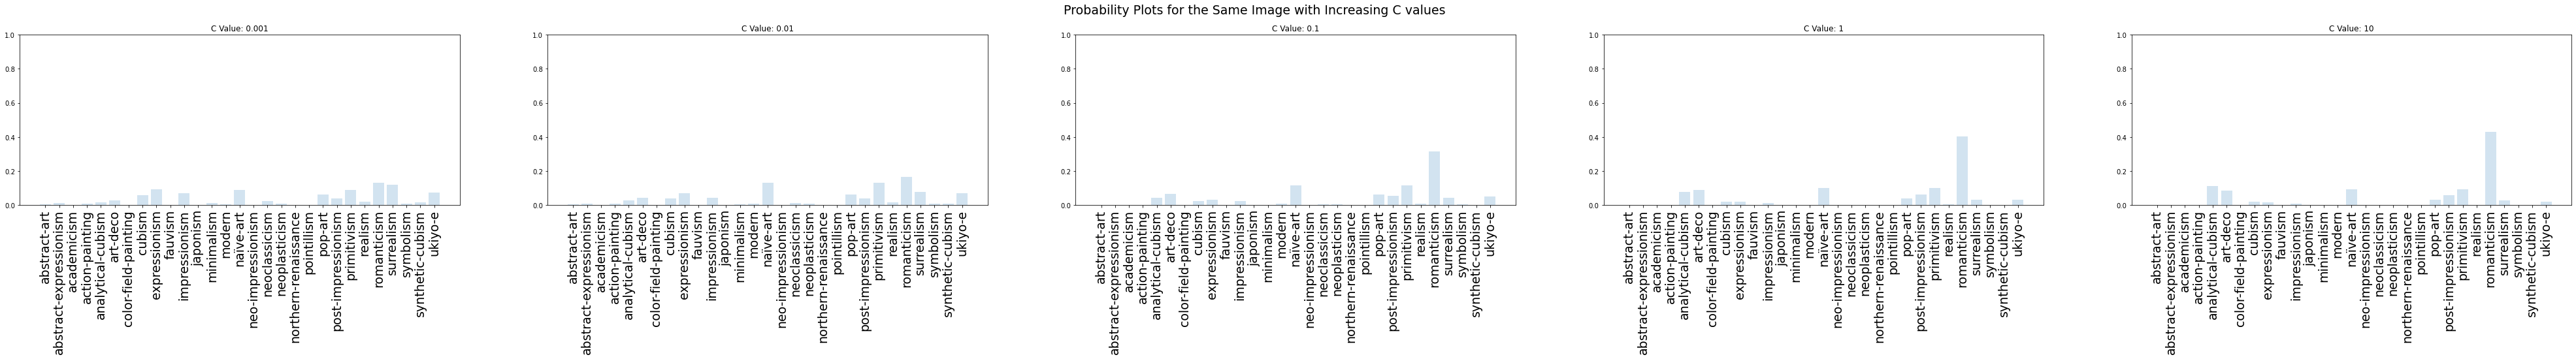

In [31]:
review_c_values(STYLE, multi_class = "multinomial", solver = "lbfgs", artwork_id = artwork_id, colour_system = HLS)

Processing of C values: Completed

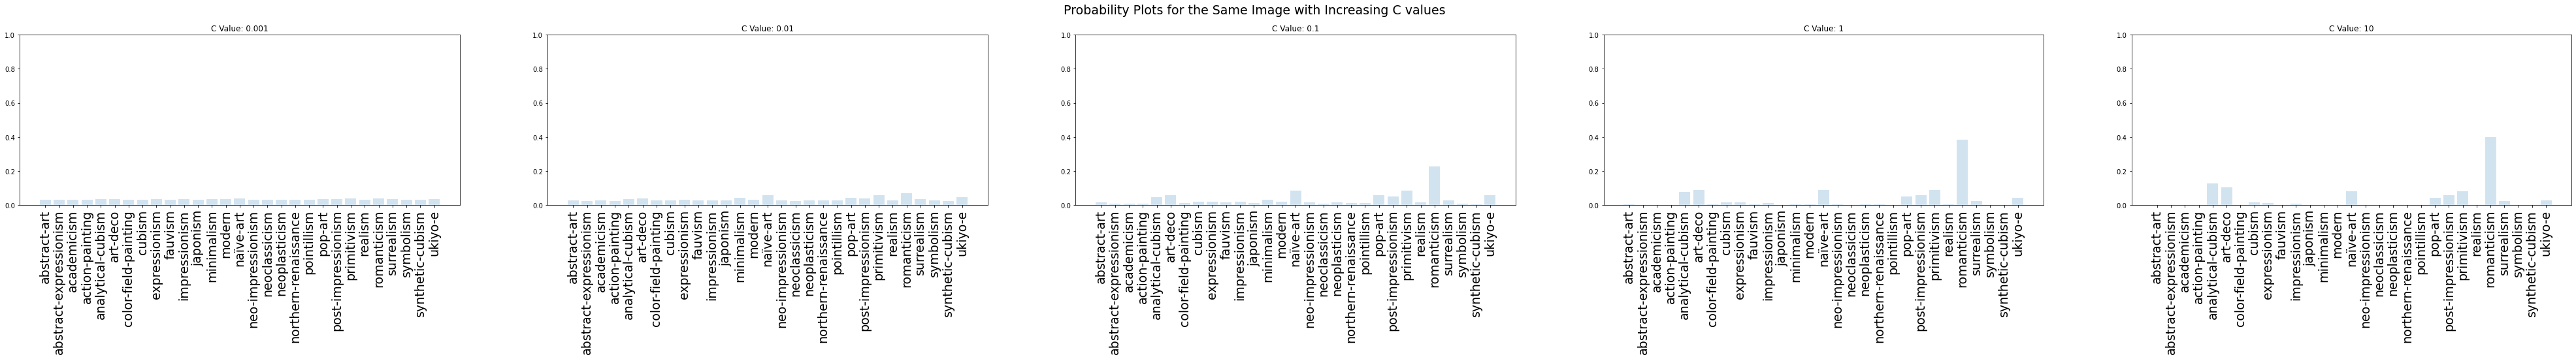

In [32]:
review_c_values(STYLE, multi_class = "ovr", solver = "liblinear", artwork_id = artwork_id, colour_system = HLS)

# NOTE: solver liblinear does not support a multinomial backend. so only an ovr backend is tested here

Processing of C values: Completed

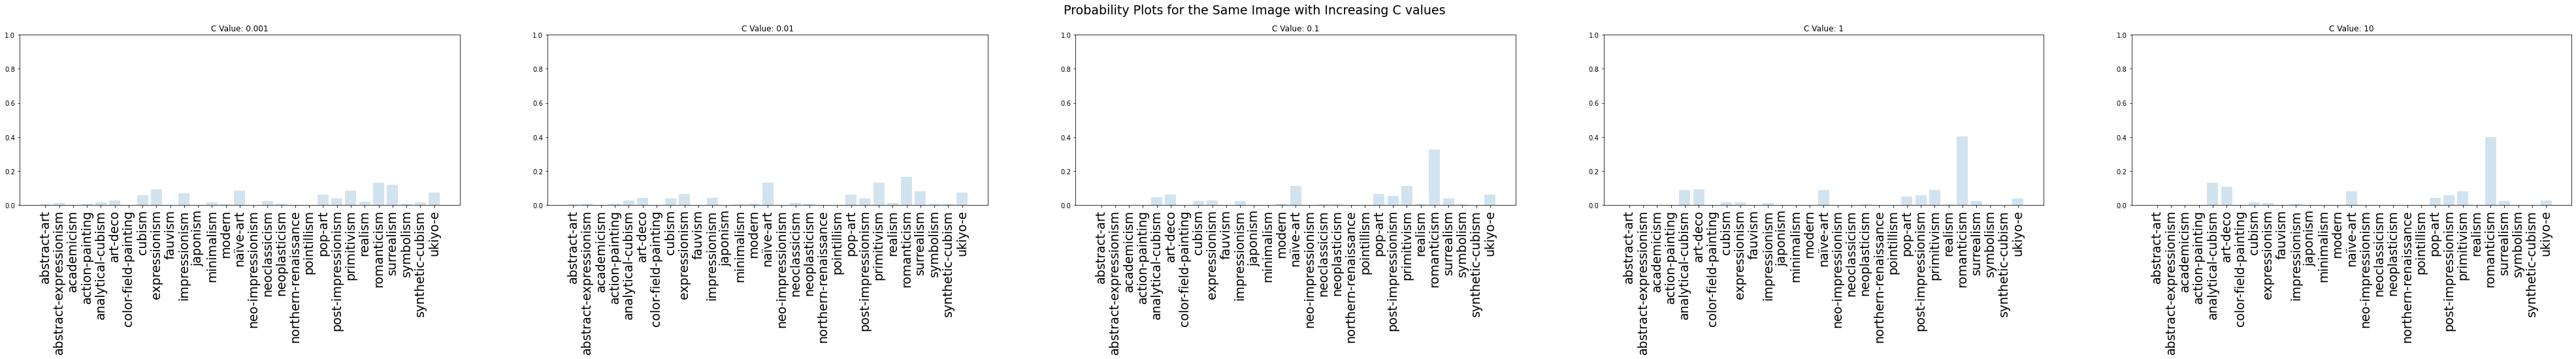

In [33]:
review_c_values(STYLE, multi_class = "ovr", solver = "sag", artwork_id = artwork_id, colour_system = HLS)

Processing of C values: Completed

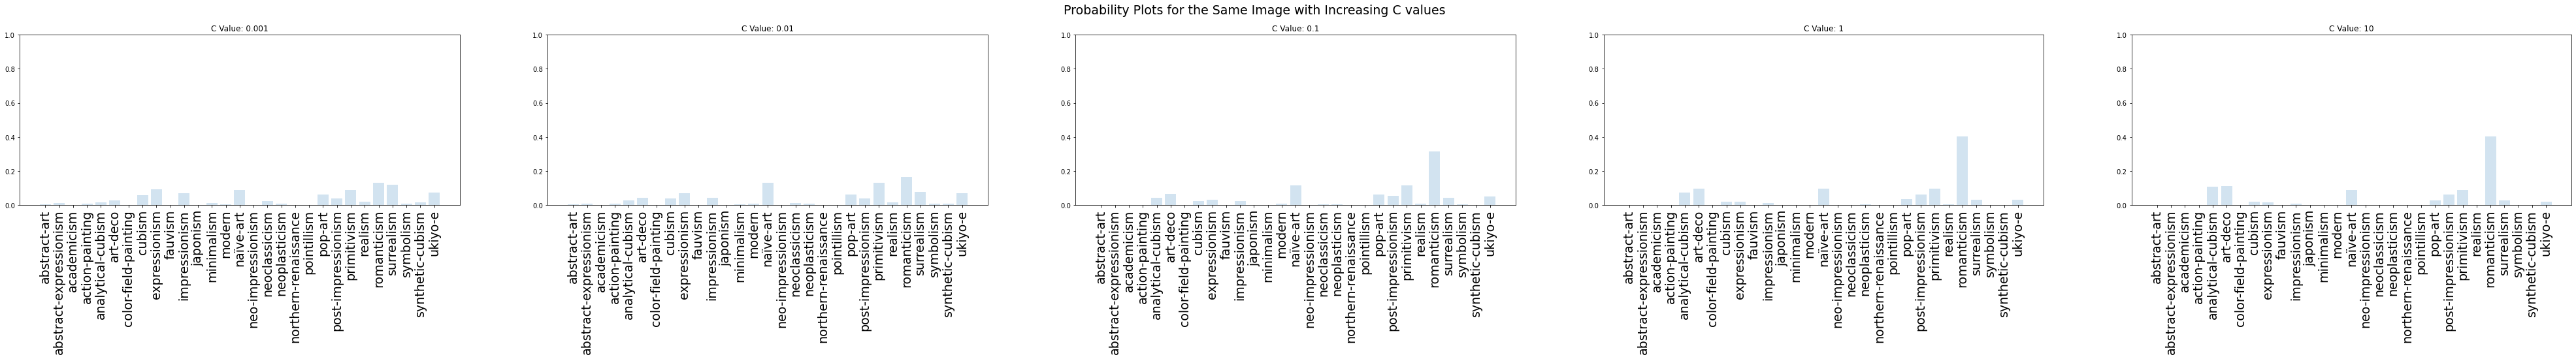

In [34]:
review_c_values(STYLE, multi_class = "multinomial", solver = "sag", artwork_id = artwork_id, colour_system = HLS)

Processing of C values: Completed

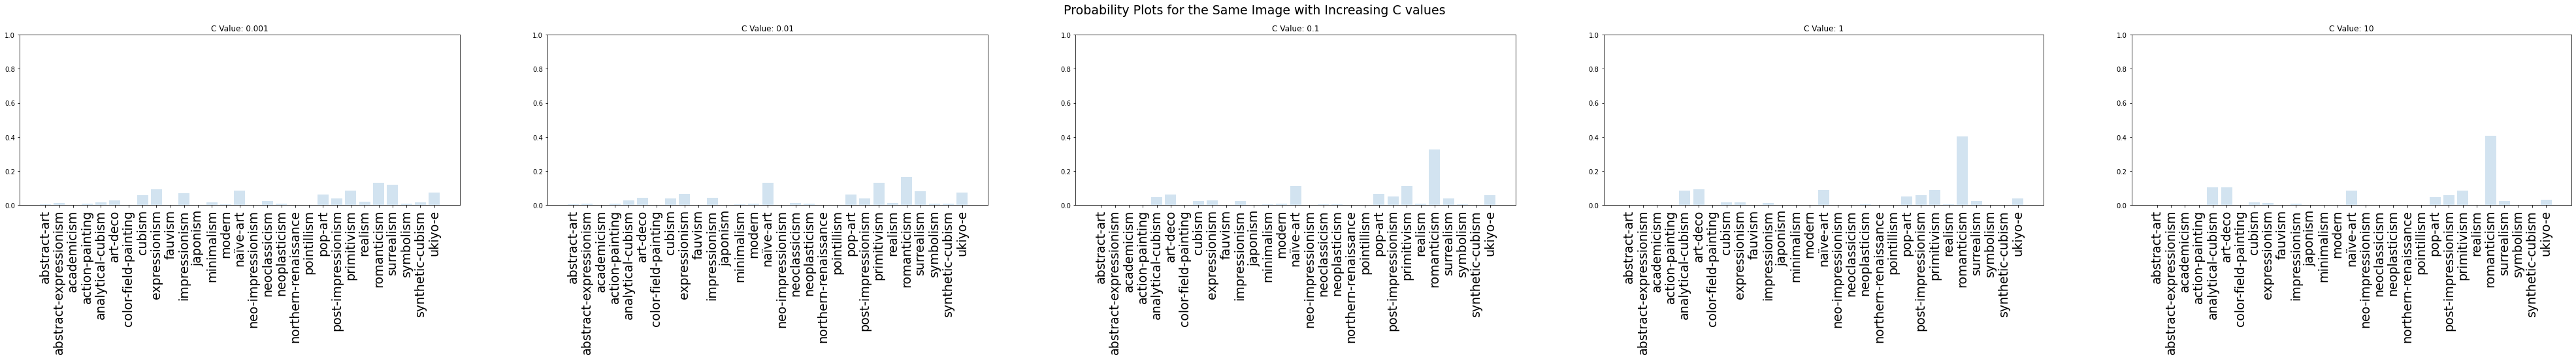

In [35]:
review_c_values(STYLE, multi_class = "ovr", solver = "saga", artwork_id = artwork_id, colour_system = HLS)

Processing of C values: Completed

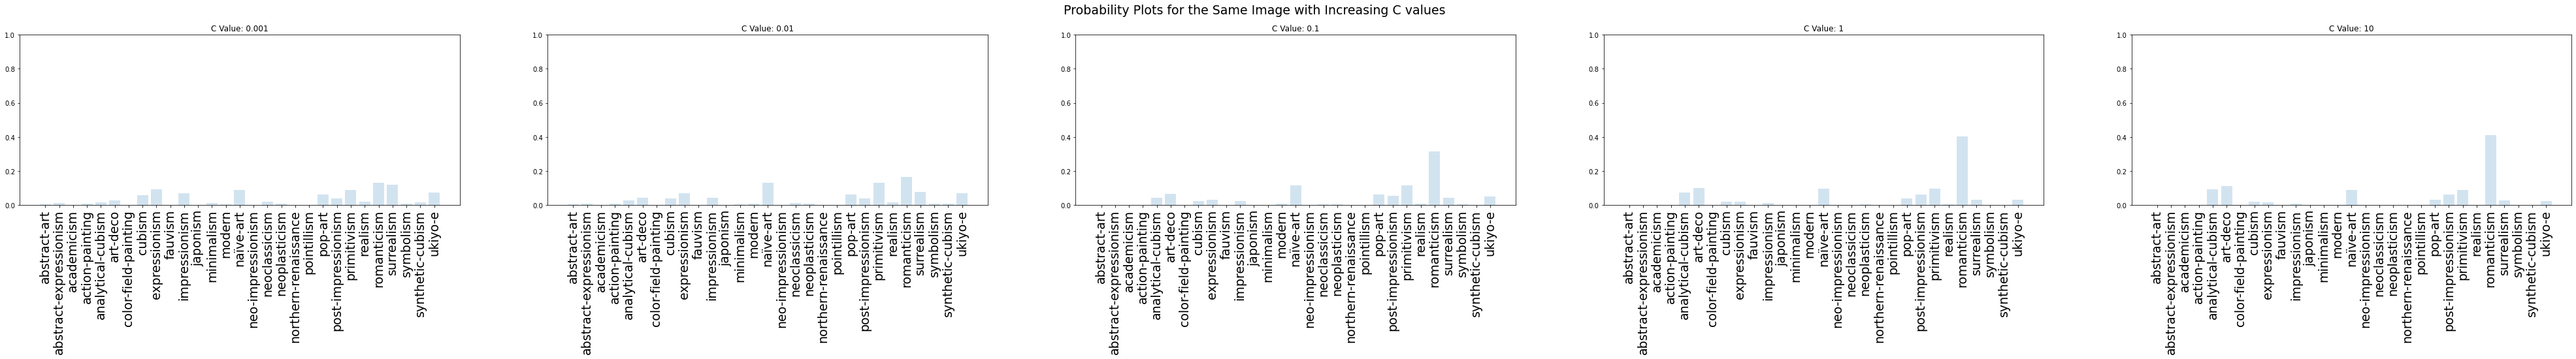

In [36]:
review_c_values(STYLE, multi_class = "multinomial", solver = "saga", artwork_id = artwork_id, colour_system = HLS)